# CS 505 FINAL PROJECT

### Importing Necessary Libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader

from transformers import AutoTokenizer, AutoModel


from transformers import AdamW

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA



In [2]:
df = pd.read_csv('train.csv')
df

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
159995,Watch muhammad ali pull the greatest prank on ...,False
159996,Some days the problem is i care too much... to...,True
159997,If someone doesn't realize their blinker is st...,True
159998,I'm going out with a girl i met online who's a...,True


### Setting labels: True=1, False=0

In [3]:
df['humor'].unique()

array([False,  True])

In [4]:
df.dtypes

text     object
humor      bool
dtype: object

In [5]:
df['humor'] = df['humor'].astype(int)

### Plot to see the distribution of humor and non-humor texts

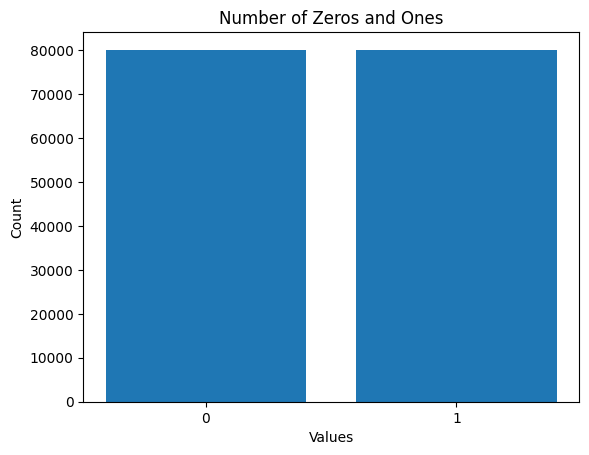

In [6]:
value_counts = df['humor'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.xticks([0, 1])
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Number of Zeros and Ones')
plt.show()

### Splitting Data into training, testing and validation sets

In [17]:
train_text, val_text, train_labels, val_labels = train_test_split(df['text'].values, df['humor'].values, test_size=0.1)

In [19]:
vectorizer = TfidfVectorizer(ngram_range = (1,2), max_features = 2000)

train_vectors = vectorizer.fit_transform(train_text).toarray()
val_vectors = vectorizer.transform(val_text).toarray()

In [20]:

pca = PCA(n_components=200)

train_vectors_pca = pca.fit_transform(train_vectors)
val_vectors_pca = pca.transform(val_vectors)


In [21]:
train_dataset = TensorDataset(torch.tensor(train_vectors_pca).float(), torch.tensor(train_labels).float())
val_dataset = TensorDataset(torch.tensor(val_vectors_pca).float(), torch.tensor(val_labels).float())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = train_vectors_pca.shape[1]

model = SimpleClassifier(input_dim).to(device)

In [28]:

loss_fn = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 25

for epoch in range(num_epochs):  
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            predictions = torch.round(torch.sigmoid(outputs.squeeze()))
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}: Accuracy on validation set: {accuracy:.2f}%")

/projectnb/cs505ws/students/bargav25/.conda/envs/lemonade/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 9000/9000 [00:10<00:00, 884.95it/s] 


Epoch 1: Accuracy on validation set: 87.04%


100%|██████████| 9000/9000 [00:08<00:00, 1088.76it/s]


Epoch 2: Accuracy on validation set: 87.57%


100%|██████████| 9000/9000 [00:09<00:00, 946.89it/s] 


Epoch 3: Accuracy on validation set: 87.67%


100%|██████████| 9000/9000 [00:10<00:00, 874.58it/s]


Epoch 4: Accuracy on validation set: 87.79%


100%|██████████| 9000/9000 [00:10<00:00, 871.67it/s]


Epoch 5: Accuracy on validation set: 87.74%


100%|██████████| 9000/9000 [00:10<00:00, 871.88it/s]


Epoch 6: Accuracy on validation set: 87.81%


100%|██████████| 9000/9000 [00:10<00:00, 872.62it/s]


Epoch 7: Accuracy on validation set: 87.72%


100%|██████████| 9000/9000 [00:10<00:00, 874.10it/s]


Epoch 8: Accuracy on validation set: 87.85%


100%|██████████| 9000/9000 [00:10<00:00, 874.33it/s]


Epoch 9: Accuracy on validation set: 87.86%


100%|██████████| 9000/9000 [00:10<00:00, 875.35it/s]


Epoch 10: Accuracy on validation set: 87.89%


100%|██████████| 9000/9000 [00:10<00:00, 873.88it/s]


Epoch 11: Accuracy on validation set: 87.83%


100%|██████████| 9000/9000 [00:10<00:00, 873.88it/s]


Epoch 12: Accuracy on validation set: 87.97%


100%|██████████| 9000/9000 [00:10<00:00, 873.69it/s]


Epoch 13: Accuracy on validation set: 88.01%


100%|██████████| 9000/9000 [00:10<00:00, 873.93it/s]


Epoch 14: Accuracy on validation set: 87.96%


100%|██████████| 9000/9000 [00:10<00:00, 874.55it/s]


Epoch 15: Accuracy on validation set: 88.11%


100%|██████████| 9000/9000 [00:10<00:00, 873.97it/s]


Epoch 16: Accuracy on validation set: 88.08%


100%|██████████| 9000/9000 [00:10<00:00, 875.64it/s]


Epoch 17: Accuracy on validation set: 88.14%


100%|██████████| 9000/9000 [00:10<00:00, 874.91it/s]


Epoch 18: Accuracy on validation set: 88.23%


100%|██████████| 9000/9000 [00:10<00:00, 875.90it/s]


Epoch 19: Accuracy on validation set: 88.28%


100%|██████████| 9000/9000 [00:10<00:00, 875.44it/s]


Epoch 20: Accuracy on validation set: 88.29%


100%|██████████| 9000/9000 [00:10<00:00, 874.33it/s]


Epoch 21: Accuracy on validation set: 88.33%


100%|██████████| 9000/9000 [00:10<00:00, 874.77it/s]


Epoch 22: Accuracy on validation set: 88.37%


100%|██████████| 9000/9000 [00:09<00:00, 954.28it/s] 


Epoch 23: Accuracy on validation set: 88.38%


100%|██████████| 9000/9000 [00:09<00:00, 908.01it/s] 


Epoch 24: Accuracy on validation set: 88.42%


100%|██████████| 9000/9000 [00:10<00:00, 871.76it/s]


Epoch 25: Accuracy on validation set: 88.42%


In [29]:
test_df = pd.read_csv('dev.csv')
test_df['humor'] = test_df['humor'].astype(int)

test_text = test_df.text
test_labels = test_df['humor'].values

test_vectors = vectorizer.transform(test_text).toarray()
test_vectors_pca = pca.transform(test_vectors)

test_dataset = TensorDataset(torch.tensor(test_vectors_pca).float())
test_loader = DataLoader(test_dataset, batch_size=16)



model.eval()  
predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0]
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.extend(torch.sigmoid(outputs.squeeze()).cpu().numpy())

threshold = 0.5
final_predictions = [1 if p >= threshold else 0 for p in predictions]


In [30]:
print(classification_report(test_labels, final_predictions))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     19918
           1       0.89      0.89      0.89     20082

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000

